In [14]:
import os,sys
sys.path.append('./misc/lib/python3.7/site-packages')

import math
import time
import numpy as np
import requests
import nglview as nv
import ipywidgets as widgets
import matplotlib.pyplot as plt
import hublib.ui as ui
import hublib.tool as tool
from IPython.display import Javascript, display
import parmed as pmd
import re

class ExcStruc:
    def __init__(self):
        self.nres = 0
        self.resnums = []
        self.restypes = []
        self.ham = []
        self.dips = []
        self.cents = []
            
    def reset(self):
        self.nres = 0
        self.resnums = []
        self.restypes = []
        self.ham = []
        self.dips = []
        self.cents = []
            
            

def check_atoms(RefAtNames, QuerAtNames):
    ismatch = True
    for atnm in RefAtNames:
        if(QuerAtNames.count(atnm)!=1):
            ismatch = False
    return ismatch

def find_porph(pmdstruc, xtruc):
    PORatList = list(['NA', 'NB', 'NC', 'ND'])
    for n in range(0, len(pmdstruc.residues)):
        r = pmdstruc.residues[n]
        nmlist = list()
        for at in r:
            nmlist.append(at.name)
        if(check_atoms(PORatList, nmlist)):
            if(nmlist.count('MG')==1):
                xstruc.resnums.append(n)
                xstruc.nres += 1 
                xstruc.restypes.append('CHL')
                
            else:
                xstruc.resnums.append(n)
                xstruc.nres += 1 
                xstruc.restypes.append('PHO')

    return


def find_dipoles(struc,xtruc):
    ResNums = xtruc.resnums
    DipMat = np.zeros((len(ResNums),3))
    for n in range(0, len(ResNums)):
        r = struc.residues[ResNums[n]]
        for at in r:
            if at.name=='NB':
                NB = struc.coordinates[at.idx]
            if at.name=='ND':
                ND = struc.coordinates[at.idx]
        DipMat[n,:] = NB - ND
    xtruc.dips = DipMat

def find_centers(struc, xtruc):
    ResNums = xtruc.resnums
    CentMat = np.zeros((len(ResNums),3))
    for n in range(0, len(ResNums)):
        r = struc.residues[ResNums[n]]
        cent = 0.0
        for at in r:
            if at.name=='NB':
                cent += 0.5*struc.coordinates[at.idx]
            if at.name=='ND':
                cent += 0.5*struc.coordinates[at.idx]
        CentMat[n,:] = cent
    xtruc.cents = CentMat


def std_rep(nglview, nvstruc, xstruc):
    pdbview.add_trajectory(struc)
    pdbview.clear(0)
    chltxt = ''
    photxt = ''
    for n in range(0, len(xstruc.resnums)):
        if xstruc.restypes[n]=='CHL':
            if len(chltxt)>0:
                chltxt += ' or '
            chltxt += str(xstruc.resnums[n]+1)
        if xstruc.restypes[n]=='PHO':
            if len(photxt)>0:
                photxt += ' or '
            photxt += str(xstruc.resnums[n]+1)
            
        
    pdbview.add_representation('cartoon', selection='protein', color='lightblue', opacity=0.25)
    if len(chltxt)>0:
        pdbview.add_representation('licorice', selection='('+chltxt+ ')', color='green')
        pdbview.add_representation('spacefill', selection='('+chltxt+ ') and (.MG)', color='magenta')
    if len(photxt)>0:
        pdbview.add_representation('licorice', selection='('+photxt+ ')', color='blue')
    for n in range(0, np.shape(xstruc.dips)[0]):
        cent = xstruc.cents[n,:]
        dip = xstruc.dips[n,:]
        v1 = cent - 1.5*dip
        v2 = cent + 1.5*dip
        pdbview.shape.add_arrow(v1.tolist(), v2.tolist(), [1,0,0 ], 1.0 )
        
pdbid = widgets.Text(
    value='2DRE',
    placeholder='Type something',
    description='PDB ID:',
    layout = widgets.Layout(width='4cm'),
    disabled=False
)

pdbgo = widgets.Button(
    description='Display',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to display the pdb file',
    icon='' # (FontAwesome names without the `fa-` prefix)
)

pdboutput = widgets.HTML(
    value="",
    placeholder='',
    description='',
)

Output = widgets.Output()

def clear_stage(view):
    view._clear_component_auto_completion()
    if view._trajlist:
        for traj in view._trajlist:
            view._trajlist.remove(traj)
    for component_id in view._ngl_component_ids:
        component_index = view._ngl_component_ids.index(component_id)
        view._ngl_component_ids.remove(component_id)
        view._ngl_component_names.pop(component_index)
        view._remote_call('removeComponent',
            target='Stage',
            args=[component_index,])
    view._remote_call('removeAllComponents',
            target='Stage',
            args=[0])
    view._update_component_auto_completion()


def pdbgo_onclick(b):
    global struc
    global estruc
    url = 'http://files.rcsb.org/download/'+pdbid.value+'.pdb'
    r = requests.get(url, allow_redirects=True)
    if(r.status_code==200):
        fname = pdbid.value + '.pdb'
        wfd = open(fname, 'wb')
        wfd.write(r.content)
        wfd.close()
        pdboutput.value = ''
        
        xstruc.reset()
        clear_stage(pdbview)
        struc = pmd.load_file(fname)
        find_porph(struc, xstruc)
        find_dipoles(struc, xstruc)
        find_centers(struc, xstruc)
        std_rep(pdbview, struc, xstruc)

    else:
        pdboutput.value = 'Please enter a valide PDB ID code.'

xstruc = ExcStruc()
pdbgo.on_click(pdbgo_onclick)
pdbid.on_submit(pdbgo_onclick)
pdbview = nv.NGLWidget()
pdbview._set_size('500px', '500px')
pdbbox = widgets.HBox([pdbid, pdbgo])

display(pdbbox)
display(pdboutput)
display(pdbview)
struc = pmd.structure

HTML(value='', placeholder='')

NGLWidget()

In [15]:
#Coupling Matrix based on Dipoles
N = len(xstruc.cents) #size of coupling matrix based on number of dipoles
V = np.zeros((N,N)) #coupling matrix

for m in range (0, N):
    for n in range (0, m):
        mu1 = xstruc.dips[m]/np.linalg.norm(xstruc.dips[m])
        mu2 = xstruc.dips[n]/np.linalg.norm(xstruc.dips[n])
        Rmn = (xstruc.cents[m]-xstruc.cents[n])*(1e-1)
        rmn = np.linalg.norm(Rmn)
        Rmnhat=Rmn/rmn
        V[m,n] =5.04*0.9*(((4.8)**2)*(np.dot(mu1,mu2))-3*(np.dot(mu1,Rmnhat))*(np.dot(mu2,Rmnhat)))/(rmn**3)
        
#V[np.isnan(V)] = 0  #I was recieving values 'nan' on diagonals    
V=np.nan_to_num(V) #I was recieving values 'nan' on diagonals
V = V + np.transpose(V)
print(V)

[[  0.     93.864  -9.897 -11.216]
 [ 93.864   0.    -11.378 -10.249]
 [ -9.897 -11.378   0.     92.028]
 [-11.216 -10.249  92.028   0.   ]]


In [16]:
#TrESP Method
for at in struc:
    if at.name.strip()=='NA':
        print(at.residue)

<Residue CLA[1001]; chain=A>
<Residue CLA[1001]; chain=B>
<Residue CLA[1001]; chain=C>
<Residue CLA[1001]; chain=D>


In [17]:
for resnum in xstruc.resnums:
    print("***************************")
    tstruc = struc[':'+str(resnum+1)]
    AtNames = ['MG', 'CHA', 'CHB', 'CHC', 'CHD', 'NA', 'C1A', 'C2A', 'C3A', 'C4A', 'CMA', 'CAA', 'CBA', 'CGA', 'O1A', 'O2A', 'NB', 'C1B', 'C2B', 'C3B', 'C4B', 'CMB', 'CAB', 'CBB', 'NC', 'C1C', 'C2C', 'C3C', 'C4C', 'CMC', 'CAC', 'CBC', 'ND', 'C1D', 'C2D', 'C3D', 'C4D', 'CMD', 'CAD', 'OBD', 'CBD', 'CGD', 'O1D', 'O2D', 'CED', 'C1']
    #AtNames = ['MG', 'NA', 'NB', 'NC', 'ND', 'K']
    for name in AtNames:
        atstruc = tstruc['@'+name]
        if len(atstruc.coordinates)>0:
            print('Atom ' + name + ' of Chl ' + str(resnum) + ' has these coordinates:')
            print("     " + str(atstruc.coordinates[0]))
            print("")
        else:  
            print("Error! Chl " + str(resnum) + ' was incomplete.')
            print("Could not find atom with name " + name)

***************************
Atom MG of Chl 699 has these coordinates:
     [12.006 41.016 -4.376]

Atom CHA of Chl 699 has these coordinates:
     [13.502 43.209 -6.64 ]

Atom CHB of Chl 699 has these coordinates:
     [14.717 41.458 -2.197]

Atom CHC of Chl 699 has these coordinates:
     [11.2   38.077 -2.525]

Atom CHD of Chl 699 has these coordinates:
     [ 9.972 39.812 -6.993]

Atom NA of Chl 699 has these coordinates:
     [13.865 42.232 -4.392]

Atom C1A of Chl 699 has these coordinates:
     [14.207 43.121 -5.415]

Atom C2A of Chl 699 has these coordinates:
     [15.361 43.984 -4.98 ]

Atom C3A of Chl 699 has these coordinates:
     [15.743 43.41  -3.595]

Atom C4A of Chl 699 has these coordinates:
     [14.758 42.277 -3.351]

Atom CMA of Chl 699 has these coordinates:
     [17.161 42.82  -3.648]

Atom CAA of Chl 699 has these coordinates:
     [14.9   45.466 -4.845]

Atom CBA of Chl 699 has these coordinates:
     [15.96  46.5   -4.449]

Atom CGA of Chl 699 has these coordina

In [36]:
#Coupling Matrix with TrESP

Natoms = 46
NChl = len(xstruc.cents)
ChlAtoms = np.zeros((NChl, Natoms, 3))
C = np.zeros((NChl,NChl))
h = 6.62607015e-34 #J*s
c = 2.998e10 #cm/s

for n in range(0,len(xstruc.resnums)):
    resnum = xstruc.resnums[n]
    tstruc = struc[':'+str(resnum+1)]
    AtNames = ['MG', 'CHA', 'CHB', 'CHC', 'CHD', 'NA', 'C1A', 'C2A', 'C3A', 'C4A', 'CMA', 'CAA', 'CBA', 'CGA', 'O1A', 'O2A', 'NB', 'C1B', 'C2B', 'C3B', 'C4B', 'CMB', 'CAB', 'CBB', 'NC', 'C1C', 'C2C', 'C3C', 'C4C', 'CMC', 'CAC', 'CBC', 'ND', 'C1D', 'C2D', 'C3D', 'C4D', 'CMD', 'CAD', 'OBD', 'CBD', 'CGD', 'O1D', 'O2D', 'CED', 'C1']
    for at in range(0,len(AtNames)):
        name = AtNames[at] #AtNames is a matrix with all the atoms name; (at)th name on the matrix 
        atstruc = tstruc['@'+name]
        if len(atstruc.coordinates)>0:
            ChlAtoms[n, at, :] = (atstruc.coordinates[0]) #of resnum, which atom number you are on, : (everything)

        else:
            print("Error! Chl " + str(resnum) + ' was incomplete.')
            print("Could not find atom with name " + name)
            
#Partial charge potentials from SI information
list1 = [-20.742,171.473,-52.285,-177.983,54.880,49.179,-176.145,14.161,-0.023,93.117,3.686,-0.723,0.563,-8.486,-1.273,7.964,-86.872,96.238,17.126,-27.569,181.543,21.362,8.694,25.870,-60.172,184.094,-27.645,12.196,-31.390,-1.921,12.949,2.318,144.929,-136.481,-12.055,-5.037,-197.159,-30.178,3.730,-22.673,-26.107,4.964,-4.611,2.960,-4.956,-1.510]
qA = np.array(list1)*1.0e-3 #put q in cgs units
list2 = [-21.674,106.779,-48.696,-98.725,72.726,31.683,-130.820,10.048,2.389,77.983,5.556,-1.050,0.735,-8.040,-1.330,7.091,-62.297,81.122,4.777,-9.204,106.271,16.963,10.681,34.947,-12.166,83.646,-7.420,-1.126,-44.008,-5.161,8.020,1.012,108.292,-110.812,-11.981,8.799,-125.044,-25.156,-19.250,-20.044,-11.238,5.979,-5.388,1.811,-5.256,-1.424]
qB = np.array(list2)*1.0e-3 #power operator is a little slow

for m in range (0,NChl):
    for n in range(0,m):
        for atm in range (0, Natoms): #Summation
            for atn in range(0,Natoms): #Summation
                Rmn = (ChlAtoms[m,atm,:]-ChlAtoms[n,atn,:])*(1e-8) #distance in pdb is angstrom so convert to cm
                rmn = np.linalg.norm(Rmn) 
                chargeproduct = (qA[atm]*qB[atn])*(4.80326e-10)**2 #cgs base unit - erg - g/cm**2*sec**2 - conveert values to wavenumbers; find hbar/h in cgs units; convert erg to joules (1 erg is ~10**7J) - multiple by (10^-7/planks constant)/speed of light
                #C[m,n]+= (charge)/(rmn)
                C[m,n]+= (((chargeproduct)/(rmn))*(1e-7))/(h*c)

C = C + np.transpose(C)
print(C)


[[  0.    183.258  13.235  49.998]
 [183.258   0.     49.686  15.294]
 [ 13.235  49.686   0.    189.509]
 [ 49.998  15.294 189.509   0.   ]]


In [37]:
print(np.shape(xstruc.dips))

(4, 3)


In [38]:
# Set up the frequency axis
v1 = 16000
v2 = 18000
dv = 1
vaxis = np.arange(v1,v2,dv)
spec = np.zeros(np.shape(vaxis))

# Generate a random ensemble of site energies, diagonalize, and add results to spectrum
eVals,eVecs = np.linalg.eigh(C)
eMu = np.matmul(np.transpose(eVecs), xstruc.dips)

for n in range(0,NChl):
    ndx = np.where(np.abs(vaxis-eVals[n])==np.min(np.abs(vaxis-eVals[n])))[0][0]
    spec[ndx] += eMu[n]**2/NChl

# Plot the spectrum
plt.figure()
plt.plot(vaxis, spec)
plt.title('Absorption Spectrum')

ValueError: setting an array element with a sequence.

(1,)


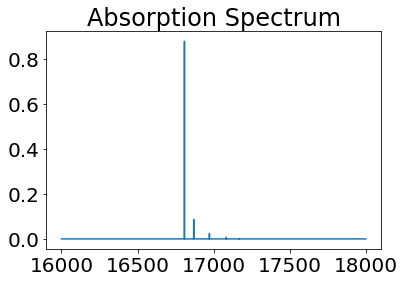

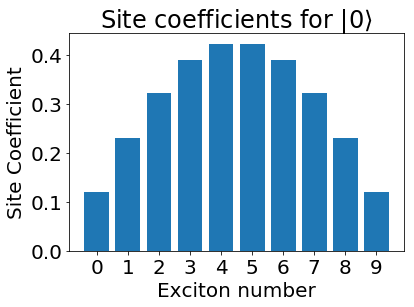

In [31]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import numpy as np
plt.rcParams.update({'font.size': 20})
np.set_printoptions(suppress=True, precision=3)

# Set parameters -- all frequencies/energies are in 1/cm
vo = 17000              # Site energy -- identical for all sites
V = -100                # Coupling constant
Nosc = 10               # Number of oscillators
Mu = np.ones((Nosc,1))  # Dipole moment matrix


# Build the Hamiltonian matrix -- we use frequency in 1/cm
H = np.zeros((Nosc,Nosc))
for n in range(0, Nosc-1):
    H[n,n+1] = V
H = H + np.transpose(H)
H = H + np.eye(Nosc)*vo

# Set up the frequency axis
v1 = 16000
v2 = 18000
dv = 1
vaxis = np.arange(v1,v2,dv)
spec = np.zeros(np.shape(vaxis))

# Generate a random ensemble of site energies, diagonalize, and add results to spectrum
eVals,eVecs = np.linalg.eig(H)
eMu = np.matmul(np.transpose(eVecs), Mu)

for n in range(0,Nosc):
    ndx = np.where(np.abs(vaxis-eVals[n])==np.min(np.abs(vaxis-eVals[n])))[0][0]
    spec[ndx] += eMu[n]**2/Nosc

# Plot the spectrum
plt.figure()
plt.plot(vaxis, spec)
plt.title('Absorption Spectrum')

# Plot the site coefficients for the lowest-energy eigenstate
plt.figure()
plt.bar(np.arange(0,Nosc), eVecs[:,0])
plt.title('Site coefficients for $|0 \\rangle$')
plt.xticks(range(0,Nosc))
plt.xlabel('Exciton number')
plt.ylabel('Site Coefficient')
plt.show()

In [19]:
#Calculate R
R = []
for n in range(0,len(xstruc.cents)):
    R1=[]
    for m in range(0, len(xstruc.cents)):
        vec = np.subtract(xstruc.cents[m], xstruc.cents[n])
        ans = np.linalg.norm(vec)
        R1.append(ans) 
    R.append(R1)
print(R)

[[0.0, 9.936760739798457, 21.212142896228094, 19.338429563953742], [9.936760739798457, 0.0, 19.257920325154533, 20.96116566415141], [21.212142896228094, 19.257920325154533, 0.0, 9.977075936866472], [19.338429563953742, 20.96116566415141, 9.977075936866472, 0.0]]


In [ ]:
r = np.power(R, 3)
print(r)

In [ ]:
#Calculate Dot Product
Mu = []
for n in range(0,len(xstruc.cents)):
    Mu1=[]
    for m in range(0, len(xstruc.cents)):
        dot = np.sum(xstruc.dips[m]*xstruc.dips[n])
        Mu1.append(dot)
    Mu.append(Mu1)
print(Mu)

In [ ]:
#Calculate R hat
Rh = []
for n in range(0,len(xstruc.cents)):
    Rh1=[]
    for m in range(0, len(xstruc.cents)):
        vect = np.subtract(xstruc.cents[m], xstruc.cents[n])
        ???
        Rh1.append(vect)
    Rh.append(Rh1)
print(Rh)

In [ ]:
answ =[]
y = []
    y([n,m]) = Rh([n,m])/R([n,m])
answ.append(y)


In [ ]:
#Calculate R hat
R2 = []
for n in range(0,len(xstruc.cents)):
    R3=[]
    answ = []
    for m in range(0, len(xstruc.cents)):
        vect = np.subtract(xstruc.cents[m], xstruc.cents[n])
        R3.append(vect)
    R2.append(R3)
    #answ = R2[n,m]/R[n,m] #how do i make matrix divide R2(1,3) by R(1,3)?
    
print(R2)

In [ ]:
#Upload Button
def done_cb(w, name):
    print("%s uploaded" % name)
    w.reset()
    
f = ui.FileUpload("Protein Data Bank file", 
               "PDB File Upload",
               dir='tmpdir',
               cb=done_cb,
               maxsize='100M')

#Run All Below Button
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(f)
display(button)

<IPython.core.display.Javascript object>

In [ ]:
Prfile=f.list()
Prfiletext=Prfile[0]
        
#ParsePDB

#Matrix for ND atom coordinates
search=open(Prfiletext,'r').readlines()
NDMatrix=[]
for line in search:
    if re.match("(HETATM)(.*ND)", line):
        y = line.split()
        if len(y)==11:
            ChlID=str(y[3])+str(y[4])
            x_coord=float(y[5])
            y_coord=float(y[6])
            z_coord=float(y[7])
            Chl_atom=y[10]
        if len(y)==10:
            ChlID=str(y[3])
            x_coord=float(y[4])
            y_coord=float(y[5])
            z_coord=float(y[6])
            Chl_atom=y[9]
        coord=[x_coord, y_coord, z_coord]
        NDMatrix.append(coord)
        print(NDMatrix)
    
#Matrix for NB atom coordinates
search=open(Prfiletext,'r').readlines()
NBMatrix=[]
for line in search:
    if re.match("(HETATM)(.*NB)", line):
        y = line.split()
        if len(y)==11:
            ChlID=str(y[3])+str(y[4])
            x_coord=float(y[5])
            y_coord=float(y[6])
            z_coord=float(y[7])
            Chl_atom=y[10]
        if len(y)==10:
            ChlID=str(y[3])
            x_coord=float(y[4])
            y_coord=float(y[5])
            z_coord=float(y[6])
            Chl_atom=y[9]
        coord=[x_coord, y_coord, z_coord]
        NBMatrix.append(coord)
        print(NBMatrix)

In [ ]:
#Calculate Dipole
D = np.subtract(NDMatrix, NBMatrix)
print(D)

In [ ]:
R = []
for n in range(0,len(D)):
    R1=[]
    for m in range(0, len(D)):
        ans = np.sqrt(np.sum(np.square(np.subtract(D[n],D[m]))))
        R1.append(ans)
    R.append(R1)
print(R)


In [ ]:
V=np.zeros(len(D),len(D))
print(V)

In [ ]:
ND=np.transpose(NDMatrix)
z = np.dot(NBMatrix,ND)
print(z)